# 1 - Introdução
Os participantes do grupo são:
- Felipe Kleine - 5992514
- Gabriel Brandão - 10737182
- Guilherme Simões - 10758748
- Isaac Bergerman - 10337575
- Jiang Zhi - 9778706
- Ricardo Felix - 13797118

O link do Google Drive é https://drive.google.com/drive/folders/10eByLk4JH07dS5MFJV7H4jAr338w6pIV?usp=sharing, o link do Git é 
https://github.com/FelipeKleine/EP-MAC0417_5768-2022.

Nessa parte do EP foi feito a segmentação manual e a segmentação automática das imagens que foram normalizadas e foram extraído informações das imagens para a  classificação.

Basicamente, essa terceira parte pode ser dividida em outras duas partes em que, a primeira parte seria a segmentação manual e automática seguida pela formação da faretbox e a segunda parte seria a partir da faretbox extrair as características da imagem e desenvolver um algoritmo para classificação dos objetos. As Figuras 6 e 7 ilustram essas etapas.






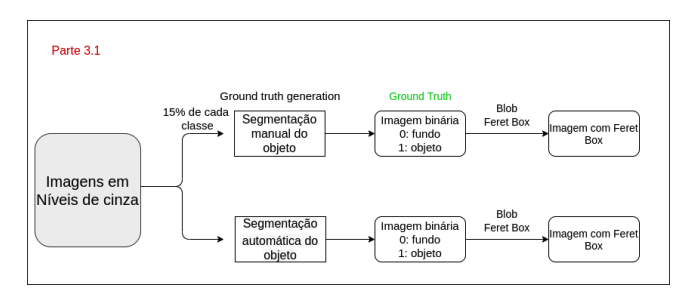

Na figura da parte 3.1, observamos que vamos ter que separar 15% de cada classe para fazer a segmentação manual do objeto, onde vamos fazer a segmentação entre o fundo e o objeto.

Após a aplicação vamos gerar o ground truth



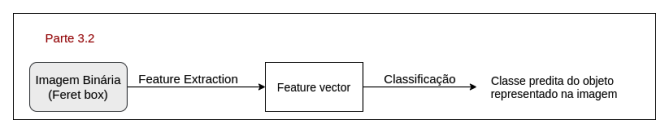

# 2 - Segmentação manual
Para a parte de segmentação manual para gerar o ground truth foi utilizado o software de Photoshop.






# 3 - Segmentação automática

Para essa parte foi realizado uma segmentanção da seguinte maneira:
- Aplicamos um filtro gaussiano com janela 7 x 7 para suavizar os ruídos, para remover os ruídos posteriormente.
- Aplicação do algoritmo de thresholding adaptativo, para separar o objeto do fundo da imagem.
- Remover a região dos cantos da imagem que são regiões em que não tem objeto e as vezes sai da cartolina.
- Encontrar todas as regiões conexas, onde removemos as regiões menores que uma área de 300 pixels para a tentativa de remoção de ruído.

Essa parte do código faz a importação das bibliotecas, usa o Google Drive como repositório e cria a função de mostrar imagem.

In [ ]:
import skimage
import cv2
import numpy as np
import os
import pandas as pd
from skimage import io, exposure

import matplotlib.pyplot as plt

from skimage.color import rgb2gray, rgba2rgb
from skimage.transform import resize

## PCA e SVM
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score

## Train test split 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

## Jaccard Similarity Test
from sklearn.metrics import jaccard_score

## Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns


from google.colab import drive, files
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/EP-MAC0417-MAC5768-2022/')


def show(image):
  plt.figure()
  plt.figure(figsize=(50, 50))
  plt.imshow(image, cmap=plt.cm.gray) 
  plt.show() 

Mounted at /content/drive


Essa parte do código é a segmentação automática

In [ ]:
# Parte de segmentação automática

def segmentation(image):
  ## Usando Adaptative Threshold
  blurred = cv2.GaussianBlur(image, (7, 7), 0)
  thresh = cv2.adaptiveThreshold(blurred, 255,
          cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 35, 4)  
  thresh[:50,:] = 0
  thresh[-50:,:] = 0
  thresh[:,:50] = 0
  thresh[:,-50:] = 0
  
  nlabels, labels, stats, centroids = cv2.connectedComponentsWithStats(thresh, None, None, None, 8, cv2.CV_32S)
  sizes = stats[1:, -1]
  thresh_2 = np.zeros((labels.shape), np.uint8)

  for i in range(0, nlabels - 1):
      if sizes[i] >= 300:
          thresh_2[labels == i + 1] = 255

  return thresh_2





Essa parte percorre os diretórios e faz a segmentação automática

In [ ]:
def automatic_segmentation():

  classes = ["Caneca", "Controle", "Garfo", "Garrafa", "Headset", "Lapis", "Livro", "Oculos", "Perfume", "Sapato"]
  if not os.path.exists(f"dataset/segmented/"):
      os.makedirs(f"dataset/segmented/")
  for object_class in classes:
    directory = f"dataset/normalized/{object_class}"
    if not os.path.exists(f"dataset/segmented/{object_class}"):
      os.makedirs(f"dataset/segmented/{object_class}")
    print(os.path.exists(directory))
    if not os.path.exists(directory):
      continue
    print(os.listdir(directory))
    for filename in os.listdir(directory):
      full_path = os.path.join(directory, filename)
      print(full_path)
      # Verifica se eh arquivo
      if os.path.isfile(full_path):
        broken = full_path.split('/')
        new_path = f"dataset/segmented/{broken[2]}/{broken[3]}"
        image = io.imread(full_path)
        image = segmentation(image)
        io.imsave(new_path, image)
        
if not os.path.exists(f"dataset/segmented/"):
  automatic_segmentation()

## 4 - Avaliação da segmentação

Para avaliar os resultados da segmentação, foram calculados a similaridade Jacardd.

Inicialmente foi feito uma pré-computacao para reduzir as imagens de ground-truth para 256 x 256.

Esse processo demora 1h para rodar.


In [ ]:
def ground_truth_resize():  
  classes = ["Caneca", "Controle", "Garfo", "Garrafa", "Headset", "Lapis", "Livro", "Oculos", "Perfume", "Sapato"]
  if not os.path.exists(f"dataset/ground_truth_resized/"):
      os.makedirs(f"dataset/ground_truth_resized/")
  for object_class in classes:
    directory = f"dataset/ground_truth/{object_class}"
    if not os.path.exists(f"dataset/ground_truth_resized/{object_class}"):
      os.makedirs(f"dataset/ground_truth_resized/{object_class}")
    if not os.path.exists(directory):
      continue

    for filename in os.listdir(directory):
      full_path = os.path.join(directory, filename)
      # Verifica se eh arquivo
      if os.path.isfile(full_path):
        broken = full_path.split('/')

        new_path = f"dataset/ground_truth_resized/{broken[2]}/{broken[3]}"
        image = io.imread(full_path)
        image = resize(image, (256, 256), anti_aliasing=True)
        image = rgb2gray(image)
        ret, image = cv2.threshold(image, 0.5, 255, cv2.THRESH_BINARY)
        image= image.astype(int)
        io.imsave(new_path, image)

if not os.path.exists(f"dataset/ground_truth_resized/"):
  ground_truth_resize()

A função jacardd_similarity, vetoriza cada uma das imagens e acha a similaridade de jacardd.

Percorremos cada ground_truth encontramos as imagens associadas a segmentação automática e fazemos a avaliação.

In [ ]:
def jacardd_similarity(img_true, img_pred):
  img_true = img_true.flatten()
  img_pred = img_pred.flatten()
  similarity = jaccard_score(img_true, img_pred, pos_label = 255) ## Colocar 0 ou 255.
  return similarity



def run_ground_truth():
  classes = ["Caneca", "Controle", "Garfo", "Garrafa", "Headset", "Lapis", "Livro", "Oculos", "Perfume", "Sapato"]
  list_jacardd = []
  for object_class in classes:

    mean_jacardd_similarity = 0.0
    total_size = 0

    directory = f"dataset/ground_truth_resized/{object_class}"
    if not os.path.exists(directory):
      continue
    for filename in os.listdir(directory):
      full_path = os.path.join(directory, filename)
      if os.path.isfile(full_path):
        broken = full_path.split('/')

        image_true = io.imread(full_path)
        #image_true = resize(image_true, (256, 256), anti_aliasing=True)
        #image_true = rgb2gray(image_true)
        #ret, image_true = cv2.threshold(image_true, 0.5, 255, cv2.THRESH_BINARY)
        #image_true = image_true.astype(int)
        #show(image_true)

        params = broken[3].split('_')
        
        for i in range(1, 6):
          params[-1] = f"0{i}.jpg"
          broken[3] = '_'.join(params)
          reconstruct_path = f"dataset/segmented/{broken[2]}/{broken[3]}"

          image_pred = io.imread(reconstruct_path)
          ret, image_pred = cv2.threshold(image_pred, 127, 255, cv2.THRESH_BINARY)
          image_pred = image_pred.astype(int)

          
          #show(image_pred)

          mean_jacardd_similarity += jacardd_similarity(image_true, image_pred)
          total_size += 1
      
    list_jacardd.append(mean_jacardd_similarity/total_size)

  data = {'object': classes,
          'jacardd': list_jacardd}
  df = pd.DataFrame(data)

  print (df)



run_ground_truth()

     object   jacardd
0    Caneca  0.288131
1  Controle  0.311080
2     Garfo  0.319852
3   Garrafa  0.466238
4   Headset  0.470587
5     Lapis  0.228844
6     Livro  0.211103
7    Oculos  0.315831
8   Perfume  0.466920
9    Sapato  0.366225


# 5 - Extração do feretbox
A estratégia utilizada para a extração do feretbox foi pegar o menor retângulo que sai do feretbox.

Mas como existem muitos ruídos na imagem, o feretbox pode sair pegando os ruídos e aumentando a área do feretbox.

In [ ]:
def feret_box(image):
  x,y,w,h = cv2.boundingRect(image)
  image = skimage.color.gray2rgb(image)
  roi = image[y:y+h, x:x+w].copy()
  cv2.rectangle(image,(x,y),(x+w,y+h),(0,255,0),2)
  
  return image, roi



def cut_feret_box():

  classes = ["Caneca", "Controle", "Garfo", "Garrafa", "Headset", "Lapis", "Livro", "Oculos", "Perfume", "Sapato"]
  if not os.path.exists(f"dataset/feretbox/"):
      os.makedirs(f"dataset/feretbox/")
  if not os.path.exists(f"dataset/feretbox_result/"):
      os.makedirs(f"dataset/feretbox_result/")
  for object_class in classes:
    directory = f"dataset/segmented/{object_class}"
    if not os.path.exists(f"dataset/feretbox/{object_class}"):
      os.makedirs(f"dataset/feretbox/{object_class}")
    if not os.path.exists(f"dataset/feretbox_result/{object_class}"):
      os.makedirs(f"dataset/feretbox_result/{object_class}")
    if not os.path.exists(directory):
      continue

    for filename in os.listdir(directory):
      full_path = os.path.join(directory, filename)
      # Verifica se eh arquivo
      if os.path.isfile(full_path):
        broken = full_path.split('/')
        try:
          new_path = f"dataset/feretbox/{broken[2]}/{broken[3]}"
          new_path_result = f"dataset/feretbox_result/{broken[2]}/{broken[3]}"
          image = io.imread(full_path)
          image, roi = feret_box(image)
          io.imsave(new_path, roi)
          io.imsave(new_path_result, image)
        except:
          pass

        #image_new = np.array(image, dtype=np.uint8)
        #io.imsave(new_path_feret, image)
        
if not os.path.exists(f"dataset/feretbox/"):
  cut_feret_box()

Após a extração do feretbox fazemos o resize da feretbox para 128 x 128 toda imagem ter o mesmo tamanho.

In [ ]:
def feretbox_resize():  
  classes = ["Caneca", "Controle", "Garfo", "Garrafa", "Headset", "Lapis", "Livro", "Oculos", "Perfume", "Sapato"]
  if not os.path.exists(f"dataset/feretbox_resized"):
      os.makedirs(f"dataset/feretbox_resized")
  for object_class in classes:
    directory = f"dataset/feretbox/{object_class}"
    if not os.path.exists(f"dataset/feretbox_resized/{object_class}"):
      os.makedirs(f"dataset/feretbox_resized/{object_class}")
    if not os.path.exists(directory):
      continue

    for filename in os.listdir(directory):
      full_path = os.path.join(directory, filename)
      # Verifica se eh arquivo
      if os.path.isfile(full_path):
        broken = full_path.split('/')

        new_path = f"dataset/feretbox_resized/{broken[2]}/{broken[3]}"
        image = io.imread(full_path)
        image = resize(image, (128, 128), anti_aliasing=True)
        image = rgb2gray(image)
        ret, image = cv2.threshold(image, 0.5, 255, cv2.THRESH_BINARY)
        image= image.astype(int)
        io.imsave(new_path, image)

if not os.path.exists(f"dataset/feretbox_resized/"):
  feretbox_resize()

# 6 - Avaliação da extração da feretbox
Para verificar a extração da feretbox, criamos uma pasta dentro de dataset chamada feretbox_result para verificar a feretbox manualmente.

Observamos que tem alguns ruídos que atrapalham na extração do feretbox real.


# 7 - Extração de características

A estratégia utilizada para pegar as características foi pegoar a imagem e a imagem foi transformada num vetor.

Então se temos uma imagem n x m denotado pela matriz M, o vector é [$a_{1, 1}$, ...., $a_{1, n}$, $a_{2, 1}$, ... ].

# 8 - Classificador

O classificador utilizado para fazer a classificação de imagens foi a combinação de PCA com SVM.


## 8.1 - Testando internamente com os datasets internos.

Para mostrar o resultado do classificador que foi criado, usamos uma matriz de confusão. Com a matriz de confusão sabemos a percentagem de cada objeto sendo identificado como outro objeto 

In [ ]:
classes = ["Caneca", "Controle", "Garfo", "Garrafa", "Headset", "Lapis", "Livro", "Oculos", "Perfume", "Sapato"]

flat_data_arr = []
target_arr = []


## Faz o load das imagens e dos rótulos.
    
for object_class in classes:
    directory = f"dataset/feretbox_resized/{object_class}"
    for img in os.listdir(directory):
        img_array = cv2.imread(os.path.join(directory,img))
        img_array = rgb2gray(img_array)
        img_resized = img_array
        flat_data_arr.append(img_resized.flatten())
        target_arr.append(classes.index(object_class))

In [ ]:
flat_data = np.array(flat_data_arr)
target = np.array(target_arr)
df = pd.DataFrame(flat_data) #dataframe
df['Target'] = target
x = df.iloc[:,:-1] #input data 
y = df.iloc[:,-1] #output data

# Separação do conjunto de treinamento e conjunto de teste
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=77, stratify=y)


## Lembrar que tem que ter o mesmo tamanho para rodar PCA - https://stackoverflow.com/questions/25485503/valueerror-setting-an-array-element-with-a-sequence-while-using-svm-in-scikit
## Modelo de PCA
im_pca = PCA()                                                      # Cria o modelo do PCA
im_pca.fit(x_train)                                                 # Utiliza o x_train para treinar o PCA
variance_explained_list = im_pca.explained_variance_ratio_.cumsum() # Calcula a variança

x_test_pca = im_pca.transform(x_test)                                   # Realiza a transformação do PCA para o conjunto de teste x_test
x_train_pca = im_pca.transform(x_train)                                 # Realiza a transformação do PCA para o conjunto de teste x_train

In [ ]:
def svm_optimal_params():
  param_grid = {'C':[0.1,1,10,100],'gamma':[0.0001,0.001,0.1,1],'kernel':['rbf','poly']}        # Realize os testes com os parametros
  svc = svm.SVC(probability = True)                                                             # Cria o modelo de SVM
  grid = GridSearchCV(svc,param_grid)                                                           # Faz o GridSearchCV com os parametros

  grid.fit(x_train_pca,y_train)                                                                     # Adiciona o conjunto de treinamento
  print(f"O modelo foi treinado e avaliado com melhores parametros: {grid.best_params_}")       # Acha o melhor parâmetro
  return grid.best_params_                                                                      # Retornamos o melhor parâmetro

#print(svm_optimal_params())


model = svm.SVC(C=10, gamma=0.001, kernel='rbf', probability=True)                         # Rodando a função no bloco anterior achamos os melhores parâmetros
model.fit(x_train_pca,y_train)                                                                 # Treinamos o modelo

y_pred = model.predict(x_test_pca)

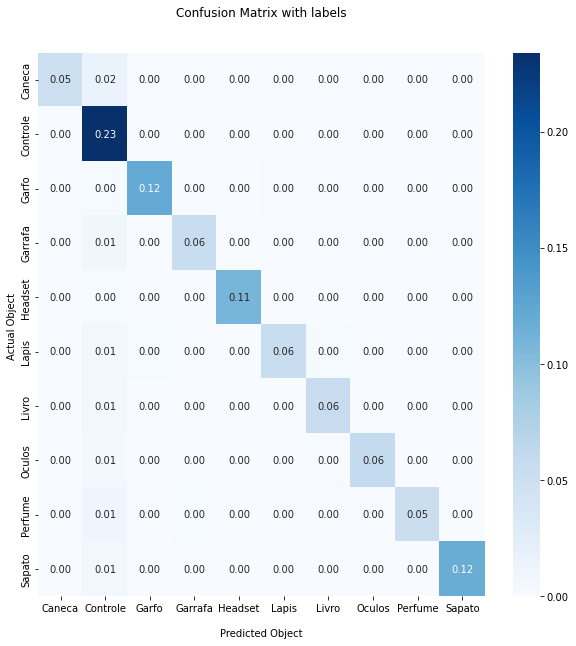

In [ ]:

def confusion_matrix_aux(y_true, y_pred):
  result = confusion_matrix(y_true, y_pred, labels=[0,1, 2, 3, 4, 5, 6, 7, 8, 9])
  return result


## https://www.stackvidhya.com/plot-confusion-matrix-in-python-and-why/
def plot_confusion_matrix(confusion_matrix):
  fig, ax = plt.subplots(figsize=(10,10))
  #sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt="d")


  confusion_matrix_normalized = confusion_matrix/np.sum(confusion_matrix)
  sns.heatmap(confusion_matrix_normalized, annot=True, cmap='Blues', fmt='.2f')
  ax.set_title('Confusion Matrix with labels\n\n');
  ax.set_xlabel('\nPredicted Object')
  ax.set_ylabel('Actual Object ');

  ## Ticket labels - List must be in alphabetical order
  ax.xaxis.set_ticklabels(["Caneca", "Controle", "Garfo", "Garrafa", "Headset", "Lapis", "Livro", "Oculos", "Perfume", "Sapato"])
  ax.yaxis.set_ticklabels(["Caneca", "Controle", "Garfo", "Garrafa", "Headset", "Lapis", "Livro", "Oculos", "Perfume", "Sapato"])

  ## Display the visualization of the Confusion Matrix.
  plt.show()



plot_confusion_matrix(confusion_matrix_aux(y_test, y_pred))


# 8.2 - Testando com objetos fora da base

Pegamos uma imagem fora da base, precisamos processar a imagem e passar por todo o processo anterior para adequar ele ao dataset.

Então a seguir temos uma classe img_processing_pipeline que realiza esse procedimento para ajustar a imagem para o classificador. Nesse procedimento  transformamos a imagem em escala de cinza, após isso transformamos na escala 256 x 256, depois fazemos a normalização do histograma da imagem e finalmente fazemos a segmentação da imagem.

Após esse procedimento conseguimos testar com o classificador.

Running Image Proncessing Pipeline...


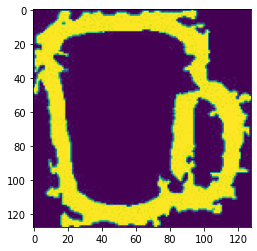

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:86: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.


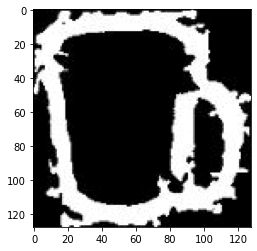

Caneca = 1.06068799885294%
Controle = 33.18571485229151%
Garfo = 0.4003174964034212%
Garrafa = 1.7163547544214495%
Headset = 10.965577042251665%
Lapis = 0.4698690972829995%
Livro = 32.32060423784886%
Oculos = 10.837064277406451%
Perfume = 2.422160182856512%
Sapato = 6.6216500603841935%
The predicted image is : Controle


In [ ]:
class img_processing_pipeline():
    def __init__(self, orig_image_path, debug=True):
        self.image = io.imread(orig_image_path)
        self.debug = debug
    
    @staticmethod
    def show(image, title):
        plt.figure()
        plt.figure(figsize=(5, 5))
        plt.title(title)
        plt.imshow(image, cmap=plt.cm.gray) 
        plt.show() 
    
    def __debug(self, title='Generic Title'):
        if self.debug == True:
            self.show(self.image, title)
            
    def gray_scale(self):
        self.image = rgb2gray(self.image)
        self.__debug('Gray Scale')
        return self
    
    def resize_image(self):
        self.image = resize(self.image, (256, 256))
        self.__debug('Resized')
        return self

    def equalize_image(self):
        self.image = exposure.equalize_hist(self.image)
        self.__debug('Equalized')
        io.imsave('normalized_image.jpg', self.image)
        return self
    
    def segmentation(self):
        self.image = io.imread('normalized_image.jpg')
        self.image = cv2.GaussianBlur(self.image, (7, 7), 0)
        self.__debug('Blurred')
        
        thresh = cv2.adaptiveThreshold(self.image, 255,
              cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 35, 4)  
        
        thresh[:50,:] = 0
        thresh[-50:,:] = 0
        thresh[:,:50] = 0
        thresh[:,-50:] = 0

        nlabels, labels, stats, centroids = cv2.connectedComponentsWithStats(thresh, None, None, None, 8, cv2.CV_32S)
        sizes = stats[1:, -1] 
        self.image = np.zeros((labels.shape), np.uint8)

        for i in range(0, nlabels - 1):
            if sizes[i] >= 300:
                self.image[labels == i + 1] = 255
        self.__debug('Threshold')
        os.remove('normalized_image.jpg')
        return self

    def feret_box(self):
        x,y,w,h = cv2.boundingRect(self.image)
        self.image = self.image[y:y+h, x:x+w].copy()
        return self

    def resize_feret_box(self):
        self.image = resize(self.image, (128, 128))
        io.imsave('final_image.jpg', self.image)
        return self

    def execute(self):
        print('Running Image Proncessing Pipeline...')
        (self
        .gray_scale()
        .resize_image()
        .equalize_image()
        .segmentation()
        .feret_box()
        .resize_feret_box())
        return 'Done'

def test_model():
  img_processing_pipeline('caneca.jpeg', False).execute()
  processed_image = "final_image.jpg"
  img=io.imread(processed_image)
  plt.imshow(img)
  plt.show()

  img_resize = rgb2gray(rgba2rgb(resize(img,(128,128)))) if '.png' in processed_image else rgb2gray(resize(img,(128,128)))
  l = [img_resize.flatten()]
  l = im_pca.transform(l)
  plt.imshow(img_resize, cmap='gray')
  plt.show()

  probability = model.predict_proba(l)
  for ind, val in enumerate(classes):
      print(f'{val} = {probability[0][ind]*100}%')
  print("The predicted image is : " + classes[model.predict(l)[0]])

test_model()

# 9 - Conclusão

A segmentação manual é um processo demorado, mas bem eficiente. A segmentação automática é um processo rapido, mas é necessário remover o máximo de ruído que conseguir, antes de começar a segmentar.

Em classificação existem bastante métodos diferentes que pode ser testado, nesse exemplo usamos PCA + SVM.

